In [15]:
%matplotlib inline
%load_ext autoreload

import numpy as np
from keras.models import load_model
import pysam

import sys
sys.path.insert(0, '/humgen/gsa-hpprojects/dev/tsato/dsde-deep-learning/api_tutorials')

from bqsr_cnn import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
sam = pysam.AlignmentFile('/seq/picard_aggregation/G94982/NA12878/current/NA12878.bam', 'rb')

In [4]:
def read_to_bqsr_tensor(read, args):
	bqsr_tensor = np.zeros((args.window_size, len(args.input_symbols)))
	bqsr_tensor[:, :4] = bqsr_base_string_to_tensor(args, read.query_sequence, read.query_qualities.tolist())
	for a in args.input_symbols:
		if a.lower() == 'strand':
			bqsr_tensor[:, args.input_symbols[a]] = float(read.is_reverse)
		elif a.lower() == 'pair':
			bqsr_tensor[:, args.input_symbols[a]] = float(read.is_read1)
		elif a.lower() == 'mq':
			bqsr_tensor[:, args.input_symbols[a]] = float(read.mapping_quality) / float(MAX_MQ)
		elif a.lower() == 'cycle':
			bqsr_tensor[:, args.input_symbols[a]] = np.arange(args.window_size) / float(args.window_size)
	return bqsr_tensor

def bqsr_get_metric_dict(labels=BQSR_LABELS):
    metrics = {}
    precision_fxns = per_class_recall_3d(labels)
    recall_fxns = per_class_recall_3d(labels)
    for i,label_key in enumerate(labels.keys()):
        metrics[label_key+'_precision'] = precision_fxns[i]
        metrics[label_key+'_recall'] = recall_fxns[i]

    return metrics

In [46]:
sys.argv = ['--window_size 151']
args = parse_args()
print(args.labels)
count = 0
model_file = '/dsde/working/sam/dsde-deep-learning/weights/bqsr_anno_try_128_160_192_224_256x_lw07.hd5'
# model = load_model(args.model, custom_objects=bqsr_get_metric_dict(args.labels))
model=load_model(model_file, custom_objects=bqsr_get_metric_dict(args.labels))

Arguments are Namespace(activation='relu', activity_weight=1.0, annotation_set='_', annotations=[], bam_file=None, base_quality_mode='phot', batch_size=32, bed_file=None, channels_last=False, chrom=None, conv_batch_normalize=False, conv_dropout=0.0, conv_layers=[128, 96, 64, 48], conv_widths=[5, 5, 5, 5], data_dir=None, downsample_homref=1.0, end_pos=0, epochs=25, fc_batch_normalize=False, fc_dropout=0.0, fc_initializer='glorot_normal', fc_layers=[32], fps=1, id='no_id', ignore_vcf=None, input_symbol_set='dna_annotations', input_symbols={'A': 0, 'C': 1, 'G': 2, 'T': 3, 'strand': 4, 'pair': 5, 'cycle': 6, 'mq': 7}, iterations=5, jitter=0.0, kernel_initializer='glorot_normal', l1=0.0, l2=0.0, label_smoothing=0.0, label_weights=[0.5, 0.5], labels={'GOOD_BASE': 0, 'BAD_BASE': 1}, learning_rate=0.01, max_pools=[], maxfun=9, mode=None, model=None, out='recalibrated.bam', output_dir='./weights/', padding='same', patience=4, random_seed=12878, read_limit=128, reference_fasta='/dsde/data/deep/v

17
198


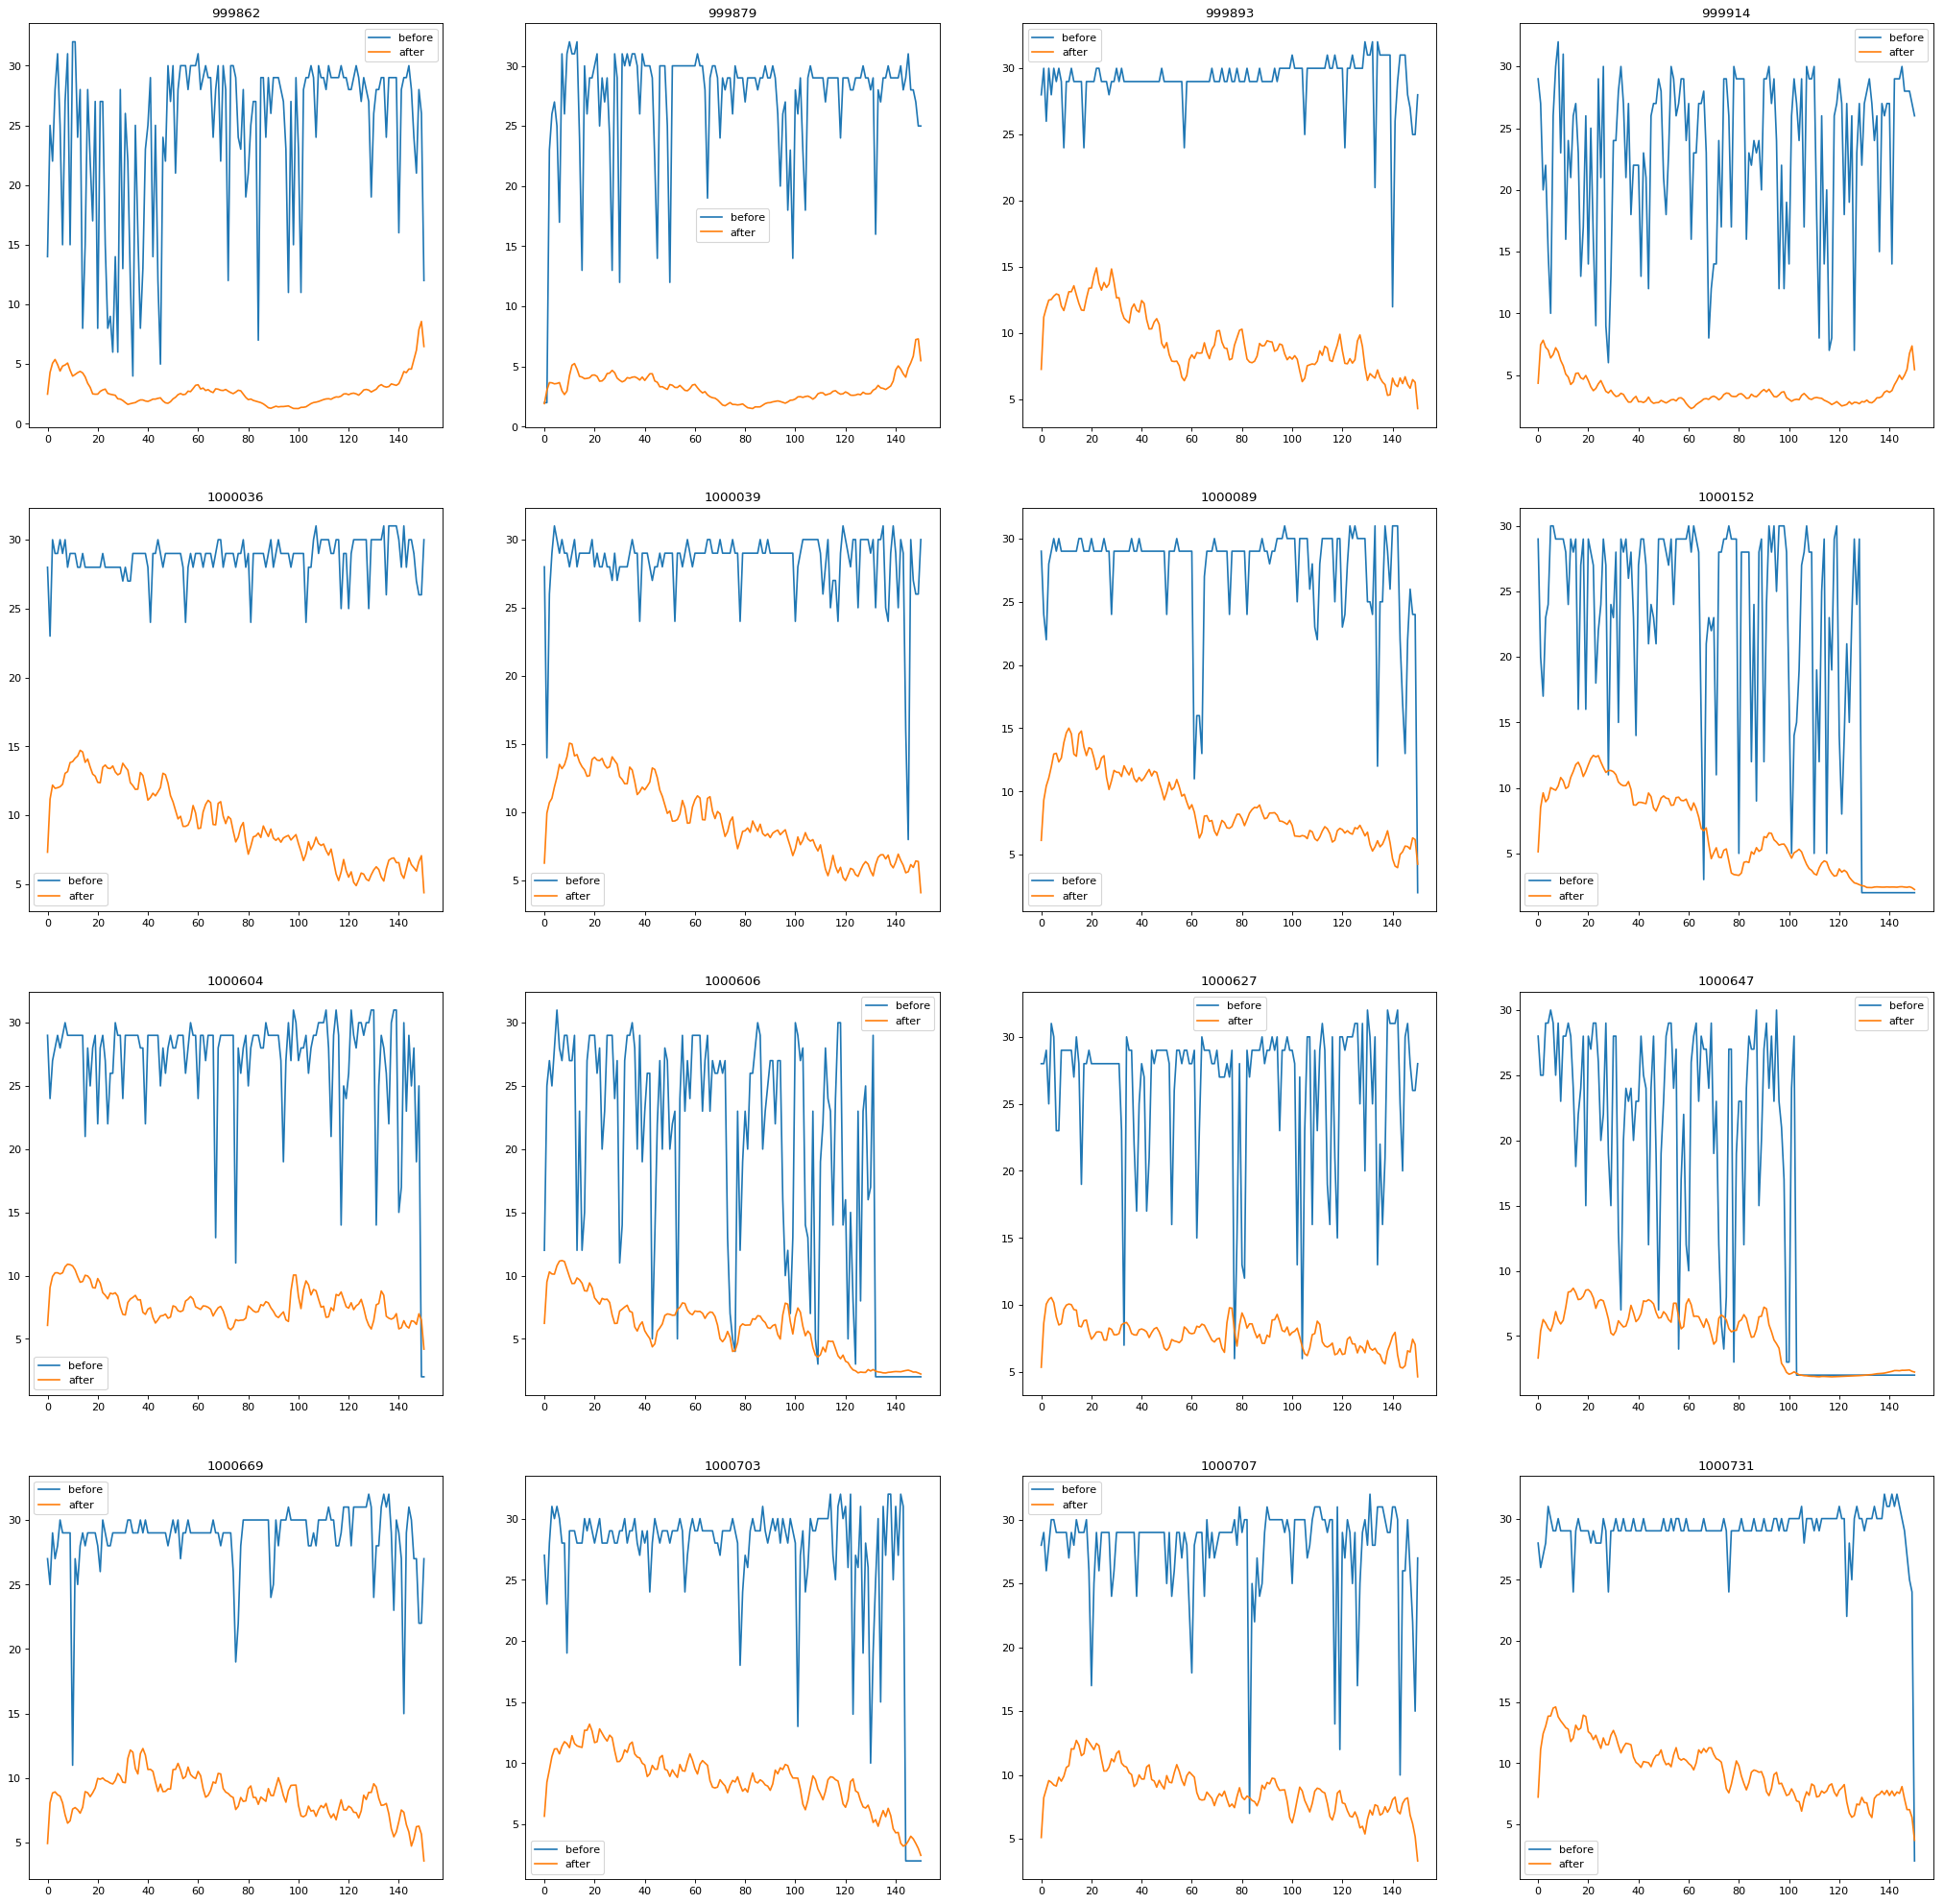

In [80]:
 # (num_reads, before/after, cycles)
num_reads_to_plot = 16
i=1
j=0

plt.figure(figsize=(32,32), dpi=80)
start = int(1e6)
end = int(20e6)
num_discarded = 0

for read in sam.fetch("1", start, end):
    if np.random.randn() < 1:
        num_discarded += 1
        continue
    if 'artificial' in read.get_tag('RG').lower():
        continue
    if not read.is_proper_pair or not read.is_paired:
        continue
    if read.is_duplicate or read.is_secondary or read.is_supplementary or read.is_qcfail or read.is_unmapped:
        continue
    if "S" in read.cigarstring:
        continue
    tensor = read_to_bqsr_tensor(read, args)
    recalibrated_tensor = model.predict(np.expand_dims(tensor, axis=0))
    plt.subplot(4, 4, i)
    before = read.query_qualities
    after = bqsr_tensor_to_bqs(np.squeeze(recalibrated_tensor), args) # after
    plt.plot(np.arange(151), before, label = "before")
    plt.plot(np.arange(151), after, label = "after")
    plt.legend()
    plt.title(read.pos)
    i += 1
    if i > num_reads_to_plot:
        break
    # recalibrated_read = bqsr_tensor_to_read(tensor, args)
print(i)
print(num_discarded)

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bqsr (InputLayer)            (None, 151, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 151, 128)          19584     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 151, 160)          307360    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 151, 192)          338112    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 151, 224)          301280    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 151, 256)          172288    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 151, 2)            514       
__________